Importing Files and Preprocessing Data

In [ ]:
import pandas as pd

# Step 1: Load the dataset
file_path = 'Book8.csv'
df = pd.read_csv(file_path)
print("Initial DataFrame:")
print(df.head())

# Step 2: Processing the 'input(url)' column - Keeping only domain names
df['input(url)'] = df['input(url)'].str.replace(r'^https?://', '', regex=True).str.split('/').str[0]

# Step 3: Creating 'Input_Domain' for further use
df['Input_Domain'] = df['input(url)']

# Step 4: Combining the 'probe_network_name' and 'probe_asn'
df['probe_asn (probe_network_name)'] = df['probe_asn'].astype(str) + " (" + df['probe_network_name'].astype(str) + ")"

# Step 5: Combining 'resolver_ip' and 'resolver_asn'
#df['resolver_asn (resolver_ip)'] = df['resolver_asn'].astype(str) + " (" + df['resolver_ip'].astype(str) + ")"

# Step 6: Combining the 'Input_Domain' and 'probe_asn (probe_network_name)' columns
#df['Domain_Probe'] = df['Input_Domain'] + ' (' + df['probe_asn (probe_network_name)'] + ')'

# Step 7: Drop the original columns to avoid redundancy
df.drop(columns=['probe_asn', 'probe_network_name'], inplace=True)

# Step 8: Reordering and keeping only required columns
final_columns = ['Input_Domain', 'measurement_start_time(UTC)', 'probe_asn (probe_network_name)', 'resolver_asn', 'resolver_ip', 'resolver_network_name', 'blocking_type']
df = df[final_columns]

# Step 9: Saving the preprocessed data to a new CSV file
output_file = "Preprocessed_Data.csv"
df.to_csv(output_file, index=False)

print("Processed DataFrame:")
print(df.head())


Initial DataFrame:
                            input(url) measurement_start_time(UTC) probe_asn  \
0                 http://www.weedy.be/            01-10-2022 00:00   AS44020   
1              http://www.xvideos.com/            01-10-2022 00:00   AS44020   
2                https://xhamster.com/            01-10-2022 00:00   AS44020   
3  http://xn--80aaifmgl1achx.xn--p1ai/            01-10-2022 00:00   AS44020   
4               https://znakomstva.ru/            01-10-2022 00:00   AS44020   

     probe_network_name resolver_asn    resolver_ip resolver_network_name  \
0  Modern Solutions LTD      AS15169  74.125.46.133            Google LLC   
1  Modern Solutions LTD      AS15169  74.125.46.133            Google LLC   
2  Modern Solutions LTD      AS15169  74.125.46.133            Google LLC   
3  Modern Solutions LTD      AS15169  74.125.46.133            Google LLC   
4  Modern Solutions LTD      AS15169  74.125.46.133            Google LLC   

  blocking_type  
0           dns  
1

Processing Datasets for classification and clustering

In [ ]:
import pandas as pd

# Step 1: Load the dataset (replace with actual file path)
# Example: file_path = 'your_dataset.csv'
df_original = pd.read_csv('Preprocessed_Data.csv')

# Ensure the class labels are strings and strip any leading/trailing spaces
df_original.iloc[:, -1] = df_original.iloc[:, -1].astype(str).str.strip().str.lower()

# Step 2: Extract non-false rows and save them in df_clustering
df_clustering = df_original[df_original.iloc[:, -1] != 'false']

# Step 3: Make a copy of the original dataframe for classification purposes
df_classification = df_original.copy()

# Step 4: Iterate through each row of df_classification and change non-false class labels to 'true'
df_classification.iloc[:, -1] = df_classification.iloc[:, -1].apply(lambda label: 'true' if label != 'false' else 'false')

# Display the first few rows of each dataframe for verification
print("Original DataFrame (df_original):")
print(df_original.head())

print("\nDataFrame for Clustering (df_clustering):")
print(df_clustering.head())

print("\nDataFrame for Classification (df_classification):")
print(df_classification.head())

# Step 5: Save the dataframes to CSV files (optional)
df_original.to_csv('df_original.csv', index=False)
df_clustering.to_csv('df_clustering.csv', index=False)
df_classification.to_csv('df_classification.csv', index=False)

Original DataFrame (df_original):
                  Input_Domain measurement_start_time(UTC)  \
0                 www.weedy.be            01-10-2022 00:00   
1              www.xvideos.com            01-10-2022 00:00   
2                 xhamster.com            01-10-2022 00:00   
3  xn--80aaifmgl1achx.xn--p1ai            01-10-2022 00:00   
4                znakomstva.ru            01-10-2022 00:00   

   probe_asn (probe_network_name) resolver_asn    resolver_ip  \
0  AS44020 (Modern Solutions LTD)      AS15169  74.125.46.133   
1  AS44020 (Modern Solutions LTD)      AS15169  74.125.46.133   
2  AS44020 (Modern Solutions LTD)      AS15169  74.125.46.133   
3  AS44020 (Modern Solutions LTD)      AS15169  74.125.46.133   
4  AS44020 (Modern Solutions LTD)      AS15169  74.125.46.133   

  resolver_network_name blocking_type  
0            Google LLC           dns  
1            Google LLC         false  
2            Google LLC         false  
3            Google LLC           dns  
4 

Classification by Constructing Decision Tree and Cross-Validating the Output

In [ ]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import KFold

# Load and preprocess the data from CSV
file_path = 'df_classification.csv'
data = []
data_= []

with open(file_path, 'r') as file:
    reader = csv.reader(file)
    headers = next(reader)  # Skip headers
    for row in reader:
        processed_row = []
        for value in row:
            if '.' in value and value.replace('.', '').isdigit():
                processed_row.append(value)
            elif value.isdigit():
                processed_row.append(int(value))
            else:
                processed_row.append(value.strip().lower())  # Normalize class labels
        data_.append(processed_row)

data = data_[:]

# Function for Gini index calculation
def gini_index(data):
    # Calculating the count of each class
    class_counts = Counter(row[-1] for row in data)
    total_samples = len(data)
    # Calculating the Gini Index for classes
    gini = 1.0 - sum((count / total_samples) ** 2 for count in class_counts.values())
    return gini

# Function for Attribute Gini index calculation
def attribute_gini_index(data, attribute_index):
    total_samples = len(data)
    value_counts = {}

    # Calculating the count of each value for every attribute
    for sample in data:
        value = sample[attribute_index]
        if value not in value_counts:
            value_counts[value] = []
        value_counts[value].append(sample)

    # Calculating the Gini Index for each value
    attribute_gini = 0.0
    for subset in value_counts.values():
        prob = len(subset) / total_samples
        attribute_gini += prob * gini_index(subset)

    return attribute_gini

# Function to build decision tree
def build_decision_tree(data, attributes):
    tree = {}
    selected_attributes = []

    # Iterating through every attribute in a dataset
    while attributes:
        best_attribute_gini = float('inf')
        best_attribute = None

        # Selecting the best attribute as a node for decision tree to split
        for attribute in attributes:
            gini = attribute_gini_index(data, attribute)
            print(f"Gini Index for Attribute {attribute}: {gini:.3f}")
            if gini < best_attribute_gini:
                best_attribute_gini = gini
                best_attribute = attribute

        if best_attribute is None:
            break

        print(f"\nSelected Attribute {best_attribute} with Weighted Gini Index = {best_attribute_gini:.3f}")
        print("-" * 100)
        attributes.remove(best_attribute)
        tree[f'Attribute_{best_attribute}'] = {}

        # Constructing subsets based on the selected nodes for further splitting
        attribute_values = set(row[best_attribute] for row in data)
        for value in attribute_values:
            subset = [row for row in data if row[best_attribute] == value]
            class_labels = [row[-1] for row in subset]
            if len(set(class_labels)) == 1:
                tree[f'Attribute_{best_attribute}'][value] = class_labels[0]
            else:
                tree[f'Attribute_{best_attribute}'][value] = subset  # Retain for further splitting

    return tree

# Prediction function for test data
def predict(tree, sample):
    for node in tree:
        attribute = int(node.split('_')[1])
        if sample[attribute] in tree[node]:
            result = tree[node][sample[attribute]]
            if isinstance(result, dict):
                return predict(result, sample)
            elif isinstance(result, list):
                return max(set([row[-1] for row in result]), key=lambda x: [row[-1] for row in result].count(x))
            else:
                return result
    return "unknown"

# Perform cross-validation to find the accuracy between test and training data
kf = KFold(n_splits=5)
fold = 1
accuracies = []
all_actual = []
all_predicted = []
class_labels = set(row[-1] for row in data)  # Unique class labels

for train_index, test_index in kf.split(data):
    train_data = [data[i] for i in train_index]
    test_data = [data[i] for i in test_index]

    print(f"\n--- Fold {fold} ---")
    attributes = list(range(len(data[0]) - 1))
    tree = build_decision_tree(train_data, attributes)

    correct_predictions = 0
    fold_actual = []
    fold_predicted = []

    for sample in test_data:
        prediction = predict(tree, sample)
        fold_actual.append(sample[-1])
        fold_predicted.append(prediction)
        if prediction == sample[-1]:
            correct_predictions += 1

    all_actual.extend(fold_actual)
    all_predicted.extend(fold_predicted)

    accuracy = correct_predictions / len(test_data)
    accuracies.append(accuracy)
    print(f"Fold {fold} Accuracy: {accuracy:.3f}")
    print("*" * 100)
    fold += 1

# Build confusion matrix to understand the accuracy
confusion_matrix = defaultdict(lambda: defaultdict(int))
for actual, predicted in zip(all_actual, all_predicted):
    confusion_matrix[actual][predicted] += 1

print("\nConfusion Matrix:")
print(f"{'':>15}", end="")
for predicted_label in sorted(class_labels):
    print(f"{predicted_label:>15}", end="")
print()

for actual_label in sorted(class_labels):
    print(f"{actual_label:>15}", end="")
    for predicted_label in sorted(class_labels):
        print(f"{confusion_matrix[actual_label][predicted_label]:>15}", end="")
    print()

# Calculating overall confidence
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"\nOverall Confidence (Mean Accuracy): {mean_accuracy:.3f}")



--- Fold 1 ---
Gini Index for Attribute 0: 0.065
Gini Index for Attribute 1: 0.280
Gini Index for Attribute 2: 0.288
Gini Index for Attribute 3: 0.292
Gini Index for Attribute 4: 0.286
Gini Index for Attribute 5: 0.293

Selected Attribute 0 with Weighted Gini Index = 0.065
----------------------------------------------------------------------------------------------------
Gini Index for Attribute 1: 0.280
Gini Index for Attribute 2: 0.288
Gini Index for Attribute 3: 0.292
Gini Index for Attribute 4: 0.286
Gini Index for Attribute 5: 0.293

Selected Attribute 1 with Weighted Gini Index = 0.280
----------------------------------------------------------------------------------------------------
Gini Index for Attribute 2: 0.288
Gini Index for Attribute 3: 0.292
Gini Index for Attribute 4: 0.286
Gini Index for Attribute 5: 0.293

Selected Attribute 4 with Weighted Gini Index = 0.286
----------------------------------------------------------------------------------------------------
Gini I

Confusion Matrix for classification

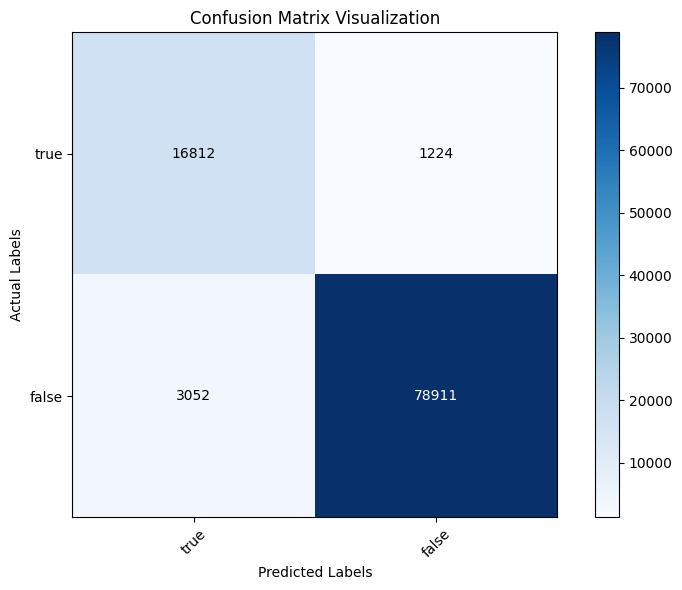

In [ ]:
# Converting the confusion matrix to a numpy array for visualization
matrix = np.array([[confusion_matrix[actual][predicted] for predicted in class_labels] for actual in class_labels])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Visualization')
plt.colorbar()

# Add labels to the heatmap
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Adding text annotations
threshold = matrix.max() / 2.0
for i, row in enumerate(matrix):
    for j, val in enumerate(row):
        plt.text(j, i, f"{val}", ha="center", va="center",
                 color="white" if val > threshold else "black")

plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()

# Display the visualization
plt.show()

In [ ]:
# Install necessary libraries
!pip install gensim pandas

Changing the Measurement Time column

In [ ]:
import pandas as pd

# Load the dataset (replace with actual file path)
file_path = 'df_clustering.csv'
df = pd.read_csv(file_path)

# Convert 'measurement_start_time(UTC)' to datetime format
df['measurement_start_time(UTC)'] = pd.to_datetime(df['measurement_start_time(UTC)'], errors='coerce', format='%d-%m-%Y %H:%M')

# Extract the day of the month
df['day'] = df['measurement_start_time(UTC)'].dt.day

# Define a function to categorize into quarters
def categorize_quarter(time):
    hour = time.hour
    if 0 <= hour < 6:
        return 'Q1'
    elif 6 <= hour < 12:
        return 'Q2'
    elif 12 <= hour < 18:
        return 'Q3'
    else:
        return 'Q4'

# Create the 'quarter' column
df['quarter'] = df['measurement_start_time(UTC)'].apply(categorize_quarter)

# Drop the original 'measurement_start_time(UTC)' column
df.drop(columns=['measurement_start_time(UTC)'], inplace=True)

# Reorder the columns to make 'day' and 'quarter' the second and third columns
cols = df.columns.tolist()
# Insert 'day' and 'quarter' as the second and third columns
new_order = [cols[0]] + ['day', 'quarter'] + cols[1:-2]
df = df[new_order]

# Display the modified DataFrame
print(df.head())

df.to_csv('df_time_change.csv', index=False)

                  Input_Domain  day quarter   probe_asn (probe_network_name)  \
0                 www.weedy.be    1      Q1   AS44020 (Modern Solutions LTD)   
1  xn--80aaifmgl1achx.xn--p1ai    1      Q1   AS44020 (Modern Solutions LTD)   
2             www.facebook.com    1      Q1  AS15493 ("Russian company" LLC)   
3            www.instagram.com    1      Q1            AS35807 (SkyNet Ltd.)   
4                  twitter.com    1      Q1            AS35807 (SkyNet Ltd.)   

  resolver_asn    resolver_ip resolver_network_name blocking_type  
0      AS15169  74.125.46.133            Google LLC           dns  
1      AS15169  74.125.46.133            Google LLC           dns  
2      AS13335   172.68.12.36      Cloudflare, Inc.          http  
3      AS35807    94.19.255.3           SkyNet Ltd.           dns  
4      AS35807    94.19.255.3           SkyNet Ltd.           dns  


Word2vec encoding for clustering

In [ ]:
# Install necessary libraries
!pip install gensim pandas numpy sklearn

# Import libraries
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from sklearn.preprocessing import normalize

# Step 1: Upload and load the CSV file
file_path = 'df_time_change.csv'
df = pd.read_csv(file_path)
print(df.head())

# Step 2: Separate features and labels
feature_columns = df.columns[:-1]  # All columns except the last one
class_labels = df.columns[-1]  # The last column (class labels)

# Step 3: Tokenize all feature values into a global corpus
global_corpus = []

for column in feature_columns:
    column_tokens = df[column].astype(str).apply(lambda x: x.split()).tolist()
    global_corpus.extend(column_tokens)

# Step 4: Train a global Word2Vec model
global_model = Word2Vec(global_corpus, vector_size=10, window=3, min_count=1, sg=0)  # CBOW

# Step 5: Embed each value using the global Word2Vec model
def embed_value(value):
    tokens = value.split()
    vectors = [global_model.wv[token] for token in tokens if token in global_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(global_model.vector_size)

for column in feature_columns:
    df[column] = df[column].astype(str).apply(embed_value)

# Normalize the embeddings
for column in feature_columns:
    df[column] = normalize(np.vstack(df[column]), axis=0)

# Step 6: Save the embedded dataset
output_filename = "global_embedded_dataset.csv"
df.to_csv(output_filename, index=False)
print(f"Embedded dataset saved to '{output_filename}'")

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
                  Input_Domain  day quarter   probe_asn (probe_network_name)  \
0                 www.weedy.be    1      Q1   AS44020 (Modern Solutions LTD)   
1  xn--80aaifmgl1achx.xn--p1ai    1      Q1   AS44020 (Modern Solutions LTD)   
2             www.facebook.com    1      Q1  AS15493 ("Russian company" LLC)   
3            www.instagram.com    1      Q1            AS35807 (SkyNet Ltd.)   
4                  twitter.com    1      Q1            AS35807 (S

K-means Clustering

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Preview of the dataset:
   Input_Domain      day   quarter  probe_asn (probe_network_name)  \
0      0.007006 -0.00086  0.009107                        0.006003   
1     -0.001384 -0.00086  0.009107                        0.006003   
2      0.000999 -0.00086  0.009107                       -0.006125   
3      0.003042 -0.00086  0.009107                       -0.001622   
4     -0.008149 -0.00086  0.009107                       -0.001622   

   resolver_asn  res

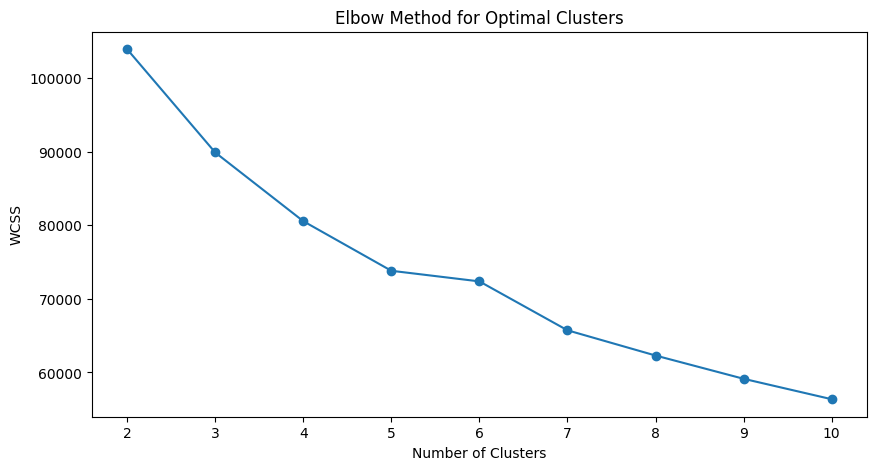

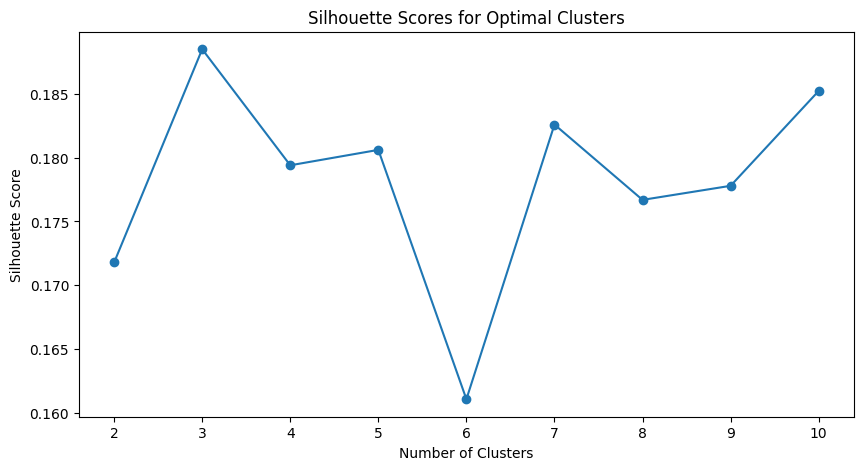

Optimal number of clusters: 3


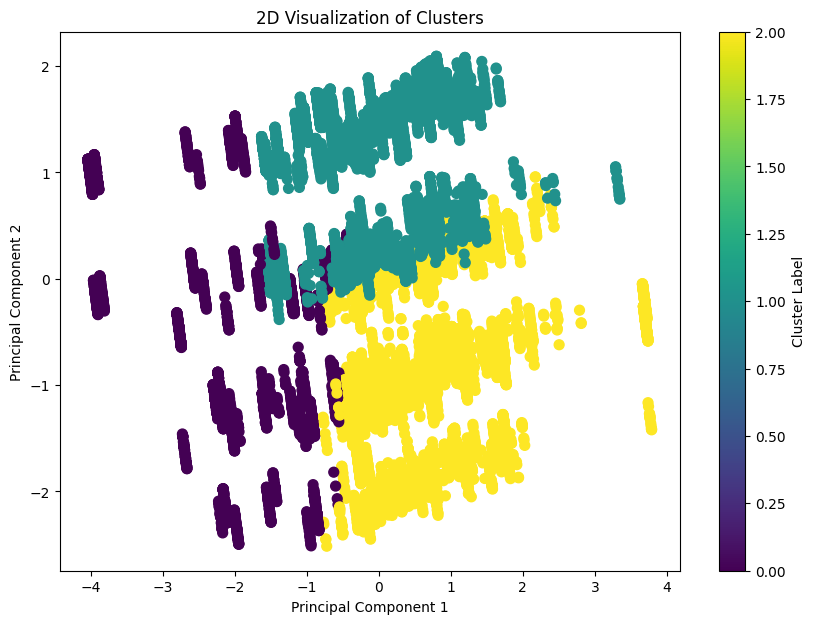

Clustered dataset with reduced features saved to 'clustered_dataset_with_visualization.csv'


In [ ]:
# Install necessary libraries
!pip install pandas matplotlib sklearn seaborn

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

csv_filename = 'global_embedded_dataset.csv'

# Load the dataset
df = pd.read_csv(csv_filename)
print("Preview of the dataset:")
print(df.head())

# Separate features and class labels
feature_columns = df.columns[:-1]  # All columns except the last one
class_labels = df.columns[-1]  # The last column (class labels)

# Step 2: Preprocess features (standardize if necessary)
features = df[feature_columns].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 3: Determine optimal number of clusters using Elbow Method
wcss = []  # Within-cluster sum of squares
silhouette_scores = []  # Silhouette scores
k_range = range(2, 11)  # Testing cluster sizes from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot the Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Step 4: Fit K-Means with the optimal number of clusters
# Choose the number of clusters based on the above plots
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)
cluster_labels = kmeans.labels_

# Step 5: Dimensionality Reduction for Visualization
# Use PCA for 2D visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Use t-SNE for an alternative visualization (optional)
# tsne = TSNE(n_components=2, random_state=42)
# reduced_features = tsne.fit_transform(scaled_features)

# Step 6: Visualize the Clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('2D Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Step 7: Save the clustered dataset with reduced features (optional)
df['Cluster_Labels'] = cluster_labels
df['PC1'] = reduced_features[:, 0]
df['PC2'] = reduced_features[:, 1]

output_filename = "clustered_dataset_with_visualization.csv"
df.to_csv(output_filename, index=False)
print(f"Clustered dataset with reduced features saved to '{output_filename}'")

RandIndex Calculation

In [ ]:
# Import libraries
import pandas as pd
from sklearn.metrics import rand_score, adjusted_rand_score
from google.colab import files

# Step 1: Upload the clustered dataset

csv_filename = 'clustered_dataset_with_visualization.csv'

# Load the dataset
df = pd.read_csv(csv_filename)
print("Preview of the dataset:")
print(df.head())

# Step 2: Extract ground-truth class labels and predicted cluster labels
ground_truth_labels = df[df.columns[-4]]  # Assuming the second-to-last column contains ground-truth labels
predicted_cluster_labels = df['Cluster_Labels']  # Assuming the last column contains cluster labels

# Step 3: Compute Rand Index and Adjusted Rand Index
ri = rand_score(ground_truth_labels, predicted_cluster_labels)
ari = adjusted_rand_score(ground_truth_labels, predicted_cluster_labels)

print(f"Rand Index (RI): {ri:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")


Preview of the dataset:
   Input_Domain      day   quarter  probe_asn (probe_network_name)  \
0      0.007006 -0.00086  0.009107                        0.006003   
1     -0.001384 -0.00086  0.009107                        0.006003   
2      0.000999 -0.00086  0.009107                       -0.006125   
3      0.003042 -0.00086  0.009107                       -0.001622   
4     -0.008149 -0.00086  0.009107                       -0.001622   

   resolver_asn  resolver_ip  resolver_network_name blocking_type  \
0     -0.000099    -0.001831              -0.003403           dns   
1     -0.000099    -0.001831              -0.003403           dns   
2     -0.001132     0.011230               0.002185          http   
3     -0.008350     0.005878              -0.000719           dns   
4     -0.008350     0.005878              -0.000719           dns   

   Cluster_Labels       PC1       PC2  
0               2  1.781159  0.567330  
1               2  1.802172  0.458724  
2               2  1